# Converting masks back to annotations

**Overview:**

![masks_to_annotations](https://user-images.githubusercontent.com/22067552/80078415-e2de0100-851c-11ea-81ce-3b2d74ee6246.png)

Most segmentation algorithms produce outputs in an image format. Visualizing these outputs in HistomicsUI requires conversion from mask images to an annotation document containing (x,y) coordinates in the whole-slide image coordinate frame. This notebook demonstrates this conversion process in two steps:

- Converting a mask image into contours (coordinates in the mask frame)

- Placing contours data into a format following the annotation document schema that can be pushed to DSA for visualization in HistomicsUI.

This notebook is based on work described in Amgad et al, 2019:

_Mohamed Amgad, Habiba Elfandy, Hagar Hussein, ..., Jonathan Beezley, Deepak R Chittajallu, David Manthey, David A Gutman, Lee A D Cooper, Structured crowdsourcing enables convolutional segmentation of histology images, Bioinformatics, 2019, btz083_

**Where to look?**

```
|_ histomicstk/
  |_annotations_and_masks/
  |   |_masks_to_annotations_handler.py
  |_tests/
      |_test_masks_to_annotations_handler.py
```

In [1]:
import os
CWD = os.getcwd()
import girder_client
from pandas import read_csv
from imageio import imread
from histomicstk.annotations_and_masks.masks_to_annotations_handler import (
    get_contours_from_mask,
    get_single_annotation_document_from_contours,
    get_annotation_documents_from_contours)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 7, 7

## 1. Connect girder client and set parameters


In [2]:
# APIURL = 'http://demo.kitware.com/histomicstk/api/v1/'
# SAMPLE_SLIDE_ID = '5bbdee92e629140048d01b5d'
APIURL = 'http://candygram.neurology.emory.edu:8080/api/v1/'
SAMPLE_SLIDE_ID = '5d586d76bd4404c6b1f286ae'

# Connect to girder client
gc = girder_client.GirderClient(apiUrl=APIURL)
gc.authenticate(interactive=True)
# gc.authenticate(apiKey='kri19nTIGOkWH01TbzRqfohaaDWb6kPecRqGmemb')

{'_accessLevel': 2,
 '_id': '59bc677892ca9a0017c2e855',
 '_modelType': 'user',
 'admin': True,
 'created': '2017-09-15T23:51:20.203000+00:00',
 'email': 'mtageld@emory.edu',
 'emailVerified': False,
 'firstName': 'Mohamed',
 'groupInvites': [],
 'groups': ['59f7713a92ca9a0017a29765',
  '5c607488e62914004d0ff4a6',
  '5e44a2e0ddda5f8398785304',
  '5e76b3f3ddda5f83982beb9a'],
 'lastName': 'Tageldin',
 'login': 'kheffah',
 'otp': False,
 'public': True,
 'size': 0,
 'status': 'enabled'}

### Let's inspect the ground truth codes file

This contains the ground truth codes and information dataframe. This is a dataframe that is indexed by the annotation group name and has the following columns:

- ``group``: group name of annotation (string), eg. "mostly_tumor"
- ``GT_code``: int, desired ground truth code (in the mask) Pixels of this value belong to corresponding group (class)
- ``color``: str, rgb format. eg. rgb(255,0,0).

**NOTE:**

Zero pixels have special meaning and do not encode specific ground truth class. Instead, they simply mean 'Outside ROI' and should be ignored during model training or evaluation.

In [3]:
# read GTCodes dataframe
GTCODE_PATH = os.path.join(
    CWD, '..', '..', 'tests', 'test_files', 'sample_GTcodes.csv')
GTCodes_df = read_csv(GTCODE_PATH)
GTCodes_df.index = GTCodes_df.loc[:, 'group']

In [4]:
GTCodes_df.head()

,group,overlay_order,GT_code,is_roi,is_background_class,color,comments
group,,,,,,,
roi,roi,0,254,1,0,"rgb(200,0,150)",NaN
evaluation_roi,evaluation_roi,0,253,1,0,"rgb(255,0,0)",NaN
mostly_tumor,mostly_tumor,1,1,0,0,"rgb(255,0,0)",core class
mostly_stroma,mostly_stroma,2,2,0,1,"rgb(255,125,0)",core class
mostly_lymphocytic_infiltrate,mostly_lymphocytic_infiltrate,1,3,0,0,"rgb(0,0,255)",core class


### Read and visualize mask

In [5]:
# read mask
X_OFFSET = 59206
Y_OFFSET = 33505
MASKNAME = "TCGA-A2-A0YE-01Z-00-DX1.8A2E3094-5755-42BC-969D-7F0A2ECA0F39" + \
    "_left-%d_top-%d_mag-BASE.png" % (X_OFFSET, Y_OFFSET)
MASKPATH = os.path.join(CWD, '..', '..', 'tests', 'test_files', 'annotations_and_masks', MASKNAME)
MASK = imread(MASKPATH)

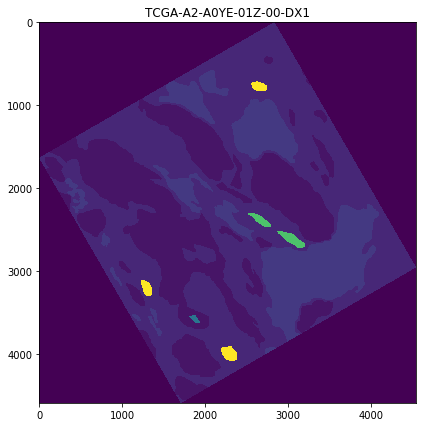

In [6]:
plt.figure(figsize=(7,7))
plt.imshow(MASK)
plt.title(MASKNAME[:23])
plt.show()

## 2. Get contours from mask

This function ``get_contours_from_mask()`` generates contours from a mask image. There are many parameters that can be set but most have defaults set for the most common use cases. The only required parameters you must provide are ``MASK`` and ``GTCodes_df``, but you may want to consider setting the following parameters based on your specific needs: ``get_roi_contour``, ``roi_group``, ``discard_nonenclosed_background``, ``background_group``, that control behaviour regarding region of interest (ROI) boundary and background pixel class (e.g. stroma).

In [7]:
print(get_contours_from_mask.__doc__)

Parse ground truth mask and gets countours for annotations.

    Parameters
    -----------
    MASK : nd array
        ground truth mask (m,n) where pixel values encode group membership.
    GTCodes_df : pandas Dataframe
        the ground truth codes and information dataframe.
        This is a dataframe that is indexed by the annotation group name and
        has the following columns.

        group: str
            group name of annotation, eg. mostly_tumor.
        GT_code: int
            desired ground truth code (in the mask). Pixels of this value
            belong to corresponding group (class).
        color: str
            rgb format. eg. rgb(255,0,0).
    groups_to_get : None
        if None (default) then all groups (ground truth labels) will be
        extracted. Otherwise pass a list fo strings like ['mostly_tumor',].
    MIN_SIZE : int
        minimum bounding box size of contour
    MAX_SIZE : None
        if not None, int. Maximum bounding box size of contour. Some

### Extract contours

In [8]:
# Let's extract all contours from a mask, including ROI boundary. We will
# be discarding any stromal contours that are not fully enclosed within a 
# non-stromal contour since we already know that stroma is the background
# group. This is so things look uncluttered when posted to DSA.
groups_to_get = None
contours_df = get_contours_from_mask(
    MASK=MASK, GTCodes_df=GTCodes_df, groups_to_get=groups_to_get,
    get_roi_contour=True, roi_group='roi',
    discard_nonenclosed_background=True,
    background_group='mostly_stroma',
    MIN_SIZE=30, MAX_SIZE=None, verbose=True,
    monitorPrefix=MASKNAME[:12] + ": getting contours")

TCGA-A2-A0YE: getting contours: non-roi: roi: NO OBJECTS!!
TCGA-A2-A0YE: getting contours: non-roi: evaluation_roi: NO OBJECTS!!
TCGA-A2-A0YE: getting contours: non-roi: mostly_tumor: getting contours
TCGA-A2-A0YE: getting contours: non-roi: mostly_tumor: adding contours
TCGA-A2-A0YE: getting contours: non-roi: mostly_stroma: getting contours
TCGA-A2-A0YE: getting contours: non-roi: mostly_stroma: adding contours
TCGA-A2-A0YE: getting contours: non-roi: nest 1 of 11: TOO SIMPLE (1 coordinates) -- IGNORED
TCGA-A2-A0YE: getting contours: non-roi: nest 2 of 11: TOO SIMPLE (2 coordinates) -- IGNORED
TCGA-A2-A0YE: getting contours: non-roi: nest 3 of 11: TOO SIMPLE (1 coordinates) -- IGNORED
TCGA-A2-A0YE: getting contours: non-roi: nest 4 of 11: TOO SIMPLE (1 coordinates) -- IGNORED
TCGA-A2-A0YE: getting contours: non-roi: nest 5 of 11: TOO SMALL (10 x 18 pixels) -- IGNORED
TCGA-A2-A0YE: getting contours: non-roi: nest 6 of 11: TOO SIMPLE (1 coordinates) -- IGNORED
TCGA-A2-A0YE: getting con

### Let's inspect the contours dataframe

The columns that really matter here are ``group``, ``color``, ``coords_x``, and ``coords_y``.

In [9]:
contours_df.head()

,group,color,ymin,ymax,xmin,xmax,has_holes,touches_edge-top,touches_edge-left,touches_edge-bottom,touches_edge-right,coords_x,coords_y
0,roi,"rgb(200,0,150)",0.0,4593.0,0.0,4541.0,0.0,1.0,1.0,1.0,1.0,"2835,2834,2833,2832,2831,2830,2829,2827,2826,2...","0,1,1,2,2,3,3,5,5,6,6,8,8,9,9,10,10,12,12,13,1..."
1,mostly_tumor,"rgb(255,0,0)",4269.0,4560.0,1639.0,2039.0,1.0,0.0,0.0,0.0,0.0,"1673,1672,1668,1667,1662,1661,1659,1658,1658,1...","4269,4270,4270,4271,4271,4272,4272,4273,4274,4..."
2,mostly_tumor,"rgb(255,0,0)",3764.0,4282.0,1607.0,2187.0,0.0,0.0,0.0,0.0,0.0,"1770,1769,1768,1767,1765,1764,1762,1761,1760,1...","3764,3765,3765,3766,3766,3767,3767,3768,3768,3..."
3,mostly_tumor,"rgb(255,0,0)",3712.0,4051.0,1201.0,1411.0,0.0,0.0,0.0,0.0,0.0,"1214,1213,1211,1210,1208,1207,1206,1205,1203,1...","3712,3713,3713,3714,3714,3715,3715,3716,3716,3..."
4,mostly_tumor,"rgb(255,0,0)",3356.0,3748.0,3108.0,3540.0,0.0,0.0,0.0,0.0,0.0,"3342,3341,3337,3336,3332,3331,3328,3327,3326,3...","3356,3357,3357,3358,3358,3359,3359,3360,3360,3..."


## 3. Get annotation documents from contours

This method ``get_annotation_documents_from_contours()`` generates formatted annotation documents from contours that can be posted to the DSA server.

In [10]:
print(get_annotation_documents_from_contours.__doc__)

Given dataframe of contours, get list of annotation documents.

    This method parses a dataframe of contours to a list of dictionaries, each
    of which represents and large_image style annotation. This is a wrapper
    that extends the functionality of the method
    get_single_annotation_document_from_contours(), whose docstring should
    be referenced for implementation details and further explanation.

    Parameters
    -----------
    contours_df : pandas DataFrame
        WARNING - This is modified inside the function, so pass a copy.
        This dataframe includes data on contours extracted from input mask
        using get_contours_from_mask(). If you have contours using some other
        method, just make sure the dataframe follows the same schema as the
        output from get_contours_from_mask(). You may find a sample dataframe
        in thie repo at ./tests/test_files/annotations_and_masks/sample_contours_df.tsv
        The following columns are relevant for this m

As mentioned in the docs, this function wraps ``get_single_annotation_document_from_contours()``

In [11]:
print(get_single_annotation_document_from_contours.__doc__)

Given dataframe of contours, get annotation document.

    This uses the large_image annotation schema to create an annotation
    document that maybe posted to DSA for viewing using something like:
    resp = gc.post("/annotation?itemId=" + slide_id, json=annotation_doc)
    The annotation schema can be found at:
    github.com/girder/large_image/blob/master/docs/annotations.md .

    Parameters
    -----------
    contours_df_slice : pandas DataFrame
        The following columns are of relevance and must be contained.

        group : str
            annotation group (ground truth label).
        color : str
            annotation color if it were to be posted to DSA.
        coords_x : str
            vertix x coordinates comma-separated values
        coords_y
            vertix y coordinated comma-separated values
    docname : str
        annotation document name
    F : float
        how much smaller is the mask where the contours come from is relative
        to the slide scan

Let's get a list of annotation documents (each is a dictionary). For the purpose of this tutorial, 
we separate the documents by group (i.e. each document is composed of polygons from the same
style/group). You could decide to allow heterogeneous groups in the same annotation document by
setting ``separate_docs_by_group`` to ``False``. We place 10 polygons in each document for this demo
for illustration purposes. Realistically you would want each document to contain several hundred depending on their complexity. Placing too many polygons in each document can lead to performance issues when rendering in HistomicsUI.

### Get annotation documents

In [12]:
# get list of annotation documents
annprops = {
    'X_OFFSET': X_OFFSET,
    'Y_OFFSET': Y_OFFSET,
    'opacity': 0.2,
    'lineWidth': 4.0,
}
annotation_docs = get_annotation_documents_from_contours(
    contours_df.copy(), separate_docs_by_group=True, annots_per_doc=10,
    docnamePrefix='demo', annprops=annprops,
    verbose=True, monitorPrefix=MASKNAME[:12] + ": annotation docs")

TCGA-A2-A0YE: annotation docs: mostly_lymphocytic_infiltrate: doc 1 of 1: contour 1 of 13
TCGA-A2-A0YE: annotation docs: mostly_lymphocytic_infiltrate: doc 1 of 1: contour 2 of 13
TCGA-A2-A0YE: annotation docs: mostly_lymphocytic_infiltrate: doc 1 of 1: contour 3 of 13
TCGA-A2-A0YE: annotation docs: mostly_lymphocytic_infiltrate: doc 1 of 1: contour 4 of 13
TCGA-A2-A0YE: annotation docs: mostly_lymphocytic_infiltrate: doc 1 of 1: contour 5 of 13
TCGA-A2-A0YE: annotation docs: mostly_lymphocytic_infiltrate: doc 1 of 1: contour 6 of 13
TCGA-A2-A0YE: annotation docs: mostly_lymphocytic_infiltrate: doc 1 of 1: contour 7 of 13
TCGA-A2-A0YE: annotation docs: mostly_lymphocytic_infiltrate: doc 1 of 1: contour 8 of 13
TCGA-A2-A0YE: annotation docs: mostly_lymphocytic_infiltrate: doc 1 of 1: contour 9 of 13
TCGA-A2-A0YE: annotation docs: mostly_lymphocytic_infiltrate: doc 1 of 1: contour 10 of 13
TCGA-A2-A0YE: annotation docs: mostly_lymphocytic_infiltrate: doc 1 of 1: contour 11 of 13
TCGA-A2-

### Let's examine one of the documents. 

Limit display to the first two elements (polygons) and cap the vertices for clarity.

In [13]:
ann_doc = annotation_docs[0].copy()
ann_doc['elements'] = ann_doc['elements'][:2]
for i in range(2):
    ann_doc['elements'][i]['points'] = ann_doc['elements'][i]['points'][:5]

In [14]:
ann_doc

{'name': 'demo_mostly_lymphocytic_infiltrate-0',
 'description': '',
 'elements': [{'group': 'mostly_lymphocytic_infiltrate',
   'type': 'polyline',
   'lineColor': 'rgb(0,0,255)',
   'lineWidth': 4.0,
   'closed': True,
   'points': [[61974.0, 37427.0, 0.0],
    [61975.0, 37428.0, 0.0],
    [61975.0, 37429.0, 0.0],
    [61976.0, 37430.0, 0.0],
    [61976.0, 37431.0, 0.0]],
   'label': {'value': 'mostly_lymphocytic_infiltrate'},
   'fillColor': 'rgba(0,0,255,0.2)'},
  {'group': 'mostly_lymphocytic_infiltrate',
   'type': 'polyline',
   'lineColor': 'rgb(0,0,255)',
   'lineWidth': 4.0,
   'closed': True,
   'points': [[60531.0, 37045.0, 0.0],
    [60528.0, 37048.0, 0.0],
    [60527.0, 37048.0, 0.0],
    [60522.0, 37053.0, 0.0],
    [60522.0, 37054.0, 0.0]],
   'label': {'value': 'mostly_lymphocytic_infiltrate'},
   'fillColor': 'rgba(0,0,255,0.2)'}]}

### Post the annotation to the correct item/slide in DSA

In [15]:
# deleting existing annotations in target slide (if any)
existing_annotations = gc.get('/annotation/item/' + SAMPLE_SLIDE_ID)
for ann in existing_annotations:
    gc.delete('/annotation/%s' % ann['_id'])

# post the annotation documents you created    
for annotation_doc in annotation_docs:
    resp = gc.post(
        "/annotation?itemId=" + SAMPLE_SLIDE_ID, json=annotation_doc)

Now you can go to HistomicsUI and confirm that the posted annotations make
sense and correspond to tissue boundaries and expected labels.